In [1]:
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from keras_helper import NNWeightHelper
from snes import SNES

Using TensorFlow backend.


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from dataSet import dataSet

In [3]:
# use just a small sample of the train set to test
SAMPLE_SIZE = 790
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 93
# how many times we will loop over ask()/tell()
GENERATIONS = 30

# input image dimensions
img_rows, img_cols = 28, 28

In [4]:
def train_classifier(model, X, y):
    X_features = model.predict(X)
    #clf = ExtraTreesClassifier(n_estimators=100, n_jobs=4)
    clf = DecisionTreeClassifier()

    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred

def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)

In [5]:
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'
paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1
print (labels)

{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desktop_computer': 6, 'desk_chair': 7, 'desk_lamp': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}


In [6]:
images_path = []
Amazon = dataSet()
dslr   = dataSet()
webcam = dataSet()

In [7]:
print('Loading webcam dataSet...')
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)
webcam.sHape()

Loading webcam dataSet...
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
done


In [8]:
print('Loading dslr dataSet...')
for dirname in files:
    images_name = os.listdir(dslr_path + '/' + dirname)
    for name in images_name:
        Image_Path = dslr_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        dslr.upData(image_data, labels[dirname], labels)
dslr.sHape()

Loading dslr dataSet...
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
done


In [9]:
x_train = webcam.data
y_train = webcam.label
x_test  = dslr.data
y_test  = dslr.label

In [10]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (795, 28, 28, 3)
y_train shape: (795,)
795 train samples
498 test samples


In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(31, activation='relu'))

# this is irrelevant for what we want to achieve
model.compile(loss="mse", optimizer="adam")
print("compilation is over")
model.summary()

compilation is over
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 31)                167679    
Total params: 168,575
Trainable params: 168,575
Non-trainable params: 0
_________________________________________________________________


In [12]:
nnw = NNWeightHelper(model)
weights = nnw.get_weights()
print("Total number of weights to evolve is:", weights.shape)

all_examples_indices = list(range(x_train.shape[0]))

clf, _ = train_classifier(model, x_train, y_train)

y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)

print('Non-trained NN Test accuracy:', test_accuracy)
# print('Test MSE:', test_mse)

Total number of weights to evolve is: (168575,)
(498,) (498,)
Non-trained NN Test accuracy: 0.0823293172690763


In [13]:
snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        # clf, _ = train_classifier(model, x_train, y_train)
        # y_pred = predict_classifier(model, clf, x_test)
        # score = accuracy_score(y_test, y_pred)
        # append to array of values that are to be returned
        told.append(score)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)

Step 1.0 : 0.9987357774968394 best: 0.9987357774968394 93
It took 14.703382357821347 seconds to complete generation 1
Step 2.0 : 0.9974715549936789 best: 0.9987357774968394 93
It took 14.555079462653264 seconds to complete generation 2
Step 3.0 : 0.9987357774968394 best: 0.9987357774968394 93
It took 14.71322768337566 seconds to complete generation 3
Step 4.0 : 0.9974715549936789 best: 0.9987357774968394 93
It took 14.692200934557292 seconds to complete generation 4
Step 5.0 : 0.9987357774968394 best: 0.9987357774968394 93
It took 14.72541730337398 seconds to complete generation 5
Step 6.0 : 0.9974715549936789 best: 0.9987357774968394 93
It took 14.642479294831176 seconds to complete generation 6
Step 7.0 : 1.0 best: 1.0 93
It took 14.522758698067207 seconds to complete generation 7
Step 8.0 : 0.9974715549936789 best: 1.0 93
It took 14.621040496955658 seconds to complete generation 8
Step 9.0 : 1.0 best: 1.0 93
It took 14.621874076543932 seconds to complete generation 9
Step 10.0 : 0.9

In [14]:
nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)

print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy:', test_accuracy)

(498,) (498,)
Test accuracy: 0.09839357429718876


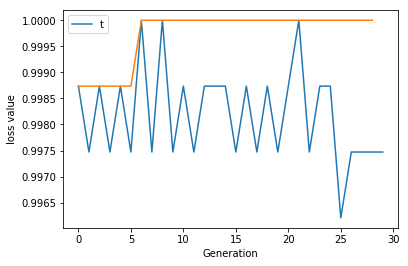

In [15]:
maxline = []
for i in range(1, len(log)):
    maxline.append(max(log[:i]))
plt.plot(log)
plt.xlabel('Generation')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.plot(maxline)
plt.savefig('log_WtoD_1.png')
plt.show()